In [2]:
import pandas as pd

df = pd.read_csv("species_occurrence.csv")
print(df.info())
print(df.head())

C:\Users\Felix Hook\AppData\Local\Temp\ipykernel_19732\12118433.py:3: DtypeWarning: Columns (10,14,20,21,36,37,38,39,40,41,44,50,127,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,231) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("species_occurrence.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68602 entries, 0 to 68601
Columns: 233 entries, key to acceptedNameUsageID
dtypes: float64(2), int64(6), object(225)
memory usage: 122.0+ MB
None
          key                            datasetKey  \
0  4510070577  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1  4512238680  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
2  4516323776  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
3  4597188954  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
4  4599839441  50c9509d-22c7-4a22-a47d-8c48425ef4a7   

                       publishingOrgKey                       installationKey  \
0  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
1  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
2  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
3  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
4  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-001

In [3]:
import numpy as np
import re

# Drop missing coordinates
df = df.dropna(subset=["decimalLatitude", "decimalLongitude"])

# Try parsing eventDate first
df["eventDate_parsed"] = pd.to_datetime(df["eventDate"], errors="coerce", utc=True)

# Where parsing failed, try constructing from year/month/day columns
mask_missing = df["eventDate_parsed"].isna()

if "year" in df.columns:
    years = pd.to_numeric(df.loc[mask_missing, "year"], errors="coerce")
    months = pd.to_numeric(df.loc[mask_missing, "month"], errors="coerce").fillna(1).astype(int)
    days = pd.to_numeric(df.loc[mask_missing, "day"], errors="coerce").fillna(1).astype(int)

    rebuilt_dates = pd.to_datetime(
        dict(year=years, month=months, day=days), errors="coerce", utc=True
    )

    df.loc[mask_missing, "eventDate_parsed"] = rebuilt_dates



In [4]:
import re

# Function to extract the first 4-digit year starting with "20" from any string
def extract_year(val):
    if pd.isna(val):
        return None
    match = re.search(r"(20\d{2})", str(val))
    return int(match.group(1)) if match else None

# Look for misplaced years in "month" and "stateProvince"
years_from_month = df["month"].map(extract_year)
years_from_state = df["stateProvince"].map(extract_year)

# Priority: month first, then stateProvince
misplaced_years = years_from_month.combine_first(years_from_state)

# Overwrite eventDate_parsed if a misplaced year exists
mask_has_year = misplaced_years.notna()

df.loc[mask_has_year, "eventDate_parsed"] = pd.to_datetime(
    misplaced_years[mask_has_year].astype(int).astype(str),
    format="%Y", errors="coerce", utc=True
)

# Clear out the wrong entries
df.loc[years_from_month.notna(), "month"] = np.nan
df.loc[years_from_state.notna(), "stateProvince"] = np.nan

# Rebuild cleaned date
df["eventDate_clean"] = df["eventDate_parsed"]
df["year_clean"] = df["eventDate_clean"].dt.year
df["month_clean"] = df["eventDate_clean"].dt.month
df["day_clean"] = df["eventDate_clean"].dt.day

In [5]:
print("Total records:", len(df))
print("Valid eventDate_clean:", df["eventDate_clean"].notna().sum())
print("Missing eventDate_clean:", df["eventDate_clean"].isna().sum())

Total records: 68361
Valid eventDate_clean: 68302
Missing eventDate_clean: 59


**Generated data as in data_cleaning -- Starting statistical tests below**

In [6]:
trends = df.groupby(["year_clean", "month_clean"]).size().reset_index(name="count")

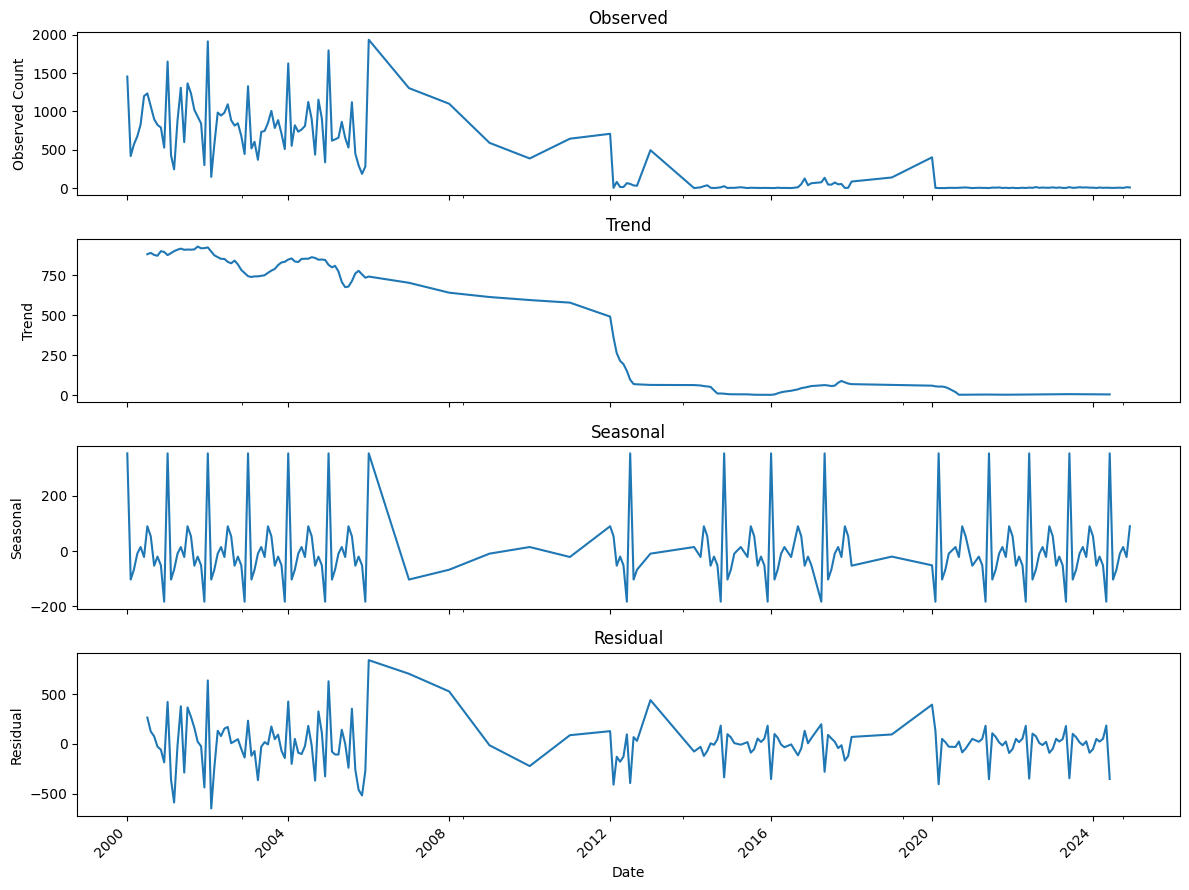

In [16]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Rename the columns so pd.to_datetime recognizes them
ts = trends.rename(
    columns={"year_clean": "year", "month_clean": "month"}
)

ts = ts.set_index(pd.to_datetime(ts[["year", "month"]].assign(day=1)))[["count"]]
                                                                       
# Decompose the time series
result = sm.tsa.seasonal_decompose(ts, model="additive", period=12)

# Create a figure manually
fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)

# Plot each component individually
result.observed.plot(ax=axes[0], legend=False, title="Observed")
result.trend.plot(ax=axes[1], legend=False, title="Trend")
result.seasonal.plot(ax=axes[2], legend=False, title="Seasonal")
result.resid.plot(ax=axes[3], legend=False, title="Residual")

# Set y-labels
axes[0].set_ylabel("Observed Count")
axes[1].set_ylabel("Trend")
axes[2].set_ylabel("Seasonal")
axes[3].set_ylabel("Residual")

# Format x-axis
for ax in axes:
    ax.set_xlabel("Date")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()
